<a href="https://colab.research.google.com/github/krisbarbier/Prediction-of-Metabolic-Syndrome/blob/main/Predictions_of_Metabolic_Syndrome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predictions of Metabolic Syndrome

##Project Overview

- Metabolic Syndrome is a group of conditions that increase the risk of heart disease, stroke, and diabetes.
- Metabolic Syndrome is identified by a person having excess body fat around the waist, high blood pressure, high triglyceride levels, low HDL levels, and high fasting glucose levels.
- This project aims to look at which of these markers are most correlated with the diagnosis of metabolic syndrome, as well as creating a machine learning model that accurately predicts whether or not a person will develop metabolic syndrome.

##Imports


In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Display all columns
pd.set_option('display.max_column', None)

#Machine Learning Imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

#Set output to pandas
from sklearn import set_config
set_config(transform_output='pandas')

##Custom Functions

In [ ]:
# Updating function
def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, target_type='reg'):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  # REGRESSION-TARGET PLOT
  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)
  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill')
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax


# Updating the function
def plot_numeric_vs_target(df, x, y, figsize=(6,4),
                           target_type='reg', estimator='mean',
                           errorbar='ci',sorted=False,ascending=False,
                           **kwargs): # kwargs for sns.regplot

  nulls = df[[x,y]].isna().sum()
  if nulls.sum()>0:
    print(f"- Excluding {nulls.sum()} NaN's")
    # print(nulls)
    temp_df = df.dropna(subset=[x,y,])
  else:
    temp_df = df
  # Create the figure
  fig, ax = plt.subplots(figsize=figsize)

  # REGRESSION-TARGET PLOT
  if 'reg' in target_type:
    # Calculate the correlation
    corr = df[[x,y]].corr().round(2)
    r = corr.loc[x,y]
    # Plot the data
    scatter_kws={'ec':'white','lw':1,'alpha':0.8}
    sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
    ## Add the title with the correlation
    ax.set_title(f"{x} vs. {y} (r = {r})")

  # CLASSIFICATION-TARGET PLOT
  elif 'class' in target_type:

    # Sort the groups by median/mean
    if sorted == True:

      if estimator == 'median':
        group_vals = temp_df.groupby(y)[x].median()
      elif estimator =='mean':
        group_vals = temp_df.groupby(y)[x].mean()

      ## Sort values
      group_vals = group_vals.sort_values(ascending=ascending)
      order = group_vals.index

    else:
      # Set order to None if not calcualted
      order = None


    # Left Subplot (barplot)
    sns.barplot(data=temp_df, x=y, y=x, order=order,  estimator=estimator,
                errorbar=errorbar, ax=ax, **kwargs)

    # Add title
    ax.set_title(f"{x} vs. {y}")

    # rotate xaxis labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


  # Final Adjustments & return
  fig.tight_layout()
  fig.show()
  return fig, ax

In [ ]:
#UNIVARIATE PLOTTING FUNCTIONS FOR EDA
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")

  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100

  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes


In [ ]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

In [ ]:
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

##Load and Inspect Data

In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Copy file path
fpath = '/content/drive/MyDrive/CodingDojo/02-MachineLearning/Metabolic  Syndrome.csv'

#Read in data with pandas
df = pd.read_csv(fpath)

#Preview first 5 rows of data
df.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


- The data loaded correctly.

In [ ]:
#Preview info with null values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seqn               2401 non-null   int64  
 1   Age                2401 non-null   int64  
 2   Sex                2401 non-null   object 
 3   Marital            2193 non-null   object 
 4   Income             2284 non-null   float64
 5   Race               2401 non-null   object 
 6   WaistCirc          2316 non-null   float64
 7   BMI                2375 non-null   float64
 8   Albuminuria        2401 non-null   int64  
 9   UrAlbCr            2401 non-null   float64
 10  UricAcid           2401 non-null   float64
 11  BloodGlucose       2401 non-null   int64  
 12  HDL                2401 non-null   int64  
 13  Triglycerides      2401 non-null   int64  
 14  MetabolicSyndrome  2401 non-null   object 
dtypes: float64(5), int64(6), object(4)
memory usage: 281.5+ KB


- There are 5 float, 6 integer, and 4 object type columns.
- The first column, seqn may not be needed for modeling.
- There are 4 columns with missing values.

In [ ]:
#Check shape of df
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns.')

There are 2401 rows and 15 columns.


##Clean Data

###Duplicates

In [ ]:
#Check for duplicate rows
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


- There are no duplicate rows to be dropped.

###Unnecessary Columns

In [ ]:
#Check unique counts for seqn column
df['seqn'].nunique()

2401

- Because this has such high cardinality, and it seems to be a unique identifier for the data, I will drop this column from the set.

In [ ]:
#Drop seqn from dataframe
df = df.drop(columns= 'seqn')

#Verify the change
df.head()

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
1,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
2,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
3,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
4,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


- The column was dropped successfully.

###Incorrect Data Types

In [ ]:
#Check column data types
df.dtypes

Age                    int64
Sex                   object
Marital               object
Income               float64
Race                  object
WaistCirc            float64
BMI                  float64
Albuminuria            int64
UrAlbCr              float64
UricAcid             float64
BloodGlucose           int64
HDL                    int64
Triglycerides          int64
MetabolicSyndrome     object
dtype: object

- All column data types are as expected, and do not need to be changed.
- I will, however, binarize the MetabolicSyndrome column to help with EDA.

In [ ]:
#Binarize MetabolicSyndrome
df['MetabolicSyndrome'] = df['MetabolicSyndrome'].replace({'No MetSyn': 0, 'MetSyn': 1})

#Verify the change
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                2401 non-null   int64  
 1   Sex                2401 non-null   object 
 2   Marital            2193 non-null   object 
 3   Income             2284 non-null   float64
 4   Race               2401 non-null   object 
 5   WaistCirc          2316 non-null   float64
 6   BMI                2375 non-null   float64
 7   Albuminuria        2401 non-null   int64  
 8   UrAlbCr            2401 non-null   float64
 9   UricAcid           2401 non-null   float64
 10  BloodGlucose       2401 non-null   int64  
 11  HDL                2401 non-null   int64  
 12  Triglycerides      2401 non-null   int64  
 13  MetabolicSyndrome  2401 non-null   int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 262.7+ KB


###Inconsistencies

In [ ]:
#Save a list of object columns
cat_cols = df.select_dtypes('object')

#Loop through cat_cols and display values
for col in cat_cols:
  print(f'Column: {col}')
  print(df[col].value_counts())
  print('\n')

Column: Sex
Female    1211
Male      1190
Name: Sex, dtype: int64


Column: Marital
Married      1192
Single        498
Divorced      242
Widowed       166
Separated      95
Name: Marital, dtype: int64


Column: Race
White          933
Black          548
Asian          349
Hispanic       257
MexAmerican    253
Other           61
Name: Race, dtype: int64




- There are no inconsistencies in these columns to fix.

###Impossible Values

In [ ]:
#Check summary statistics for impossible values and outliers
df.describe()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
count,2401.000000,2284.000000,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,48.691795,4005.253940,98.307254,28.702189,0.154102,43.626131,5.489046,108.247813,53.369429,128.125364,0.342357
std,17.632852,2954.032186,16.252634,6.662242,0.422780,258.272829,1.439358,34.820657,15.185537,95.322477,0.474597
min,20.000000,300.000000,56.200000,13.400000,0.000000,1.400000,1.800000,39.000000,14.000000,26.000000,0.000000
25%,34.000000,1600.000000,86.675000,24.000000,0.000000,4.450000,4.500000,92.000000,43.000000,75.000000,0.000000
50%,48.000000,2500.000000,97.000000,27.700000,0.000000,7.070000,5.400000,99.000000,51.000000,103.000000,0.000000
75%,63.000000,6200.000000,107.625000,32.100000,0.000000,13.690000,6.400000,110.000000,62.000000,150.000000,1.000000
max,80.000000,9000.000000,176.000000,68.700000,2.000000,5928.000000,11.300000,382.000000,156.000000,1562.000000,1.000000


- There looks like there could be an outlier in UrAlbCr, as well as HDL.

In [ ]:
#Filter out high UrAlbCr levels
df[df['UrAlbCr'] >= 1000]

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
50,80,Male,Married,2500.0,White,88.6,21.7,2,3267.57,4.7,135,44,75,0
140,80,Female,Married,2500.0,White,97.5,30.8,2,3284.62,7.8,132,65,130,1
212,74,Female,Divorced,800.0,Asian,111.7,35.3,2,1777.05,7.2,104,37,111,1
246,50,Male,Separated,2000.0,Black,75.5,19.6,2,2750.00,5.7,127,80,92,0
312,39,Female,Single,9000.0,Black,118.0,37.5,2,2238.10,7.1,291,34,248,1
324,48,Male,Married,1500.0,MexAmerican,123.0,38.5,2,2403.85,6.6,100,53,166,1
418,69,Male,Married,2500.0,Asian,93.2,27.2,2,1817.31,6.7,99,64,93,0
872,63,Female,Separated,1600.0,MexAmerican,111.5,35.2,2,1276.60,8.1,47,60,159,1
891,80,Female,Separated,2500.0,Black,103.1,30.4,2,1511.11,6.2,250,47,80,1
910,58,Male,Married,2000.0,MexAmerican,100.6,25.6,2,3666.67,8.8,211,48,188,0


- Upon further research, the higher the UrAlbCr level, the more likely this person is to have kidney disease, and could be a result of a complication from diabetes. While these levels seem very high, I will leave them as is for now.

In [ ]:
#Filter out high HDL levels
df[df['HDL'] >= 100]

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
195,55,Female,Separated,1600.0,Black,76.1,20.3,0,22.91,5.5,83,119,46,0
220,61,Male,Separated,1000.0,Black,87.2,18.7,1,37.26,7.1,105,150,74,0
304,68,Female,Married,2500.0,Black,80.4,21.5,0,4.38,5.1,90,100,61,0
403,72,Male,NaN,1600.0,MexAmerican,101.0,25.7,0,3.49,5.6,99,106,89,0
798,55,Male,Single,1600.0,White,103.8,24.4,0,5.22,5.7,88,108,77,0
862,37,Female,Single,8200.0,Black,85.2,25.9,0,3.66,4.6,92,104,37,0
959,57,Female,Divorced,6200.0,Black,77.9,21.5,0,6.52,3.4,93,138,54,0
1310,75,Female,Widowed,1000.0,Black,NaN,26.7,1,151.70,7.4,108,156,64,0
1453,79,Female,Married,9000.0,White,79.7,22.5,0,20.00,4.5,105,107,95,0
1512,73,Female,Divorced,3500.0,Black,107.2,27.8,1,39.32,6.4,97,104,97,0


- Upon further research, the HDL level is a possible level, although it is quite a bit higher than the 75% percentile in this dataset.

###Missing Values

In [ ]:
#Check missing values in each column
df.isna().sum()

Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

- The only columns with missing values are Marital, Income, WaistCirc, and BMI. Depending on the overall distributions of each of these, I will determine how to impute them when it is time to produce machine learning models.

##Feature Inspection

###Age

- Age: The patient's age.

In [ ]:
#Univariate EDA
#Comfirm data type for function call
age_feature = 'Age'
df[age_feature].dtype

dtype('int64')

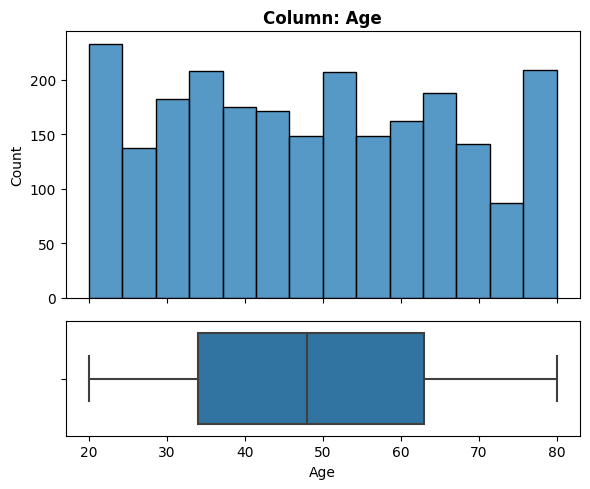

- NaN's Found: 0 (0.0%)
- Unique Values: 61
- Most common value: '80' occurs 124 times (5.16%)
- Not constant or quasi-constant.


In [ ]:
#Call numeric function
explore_numeric(df, age_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are no null values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

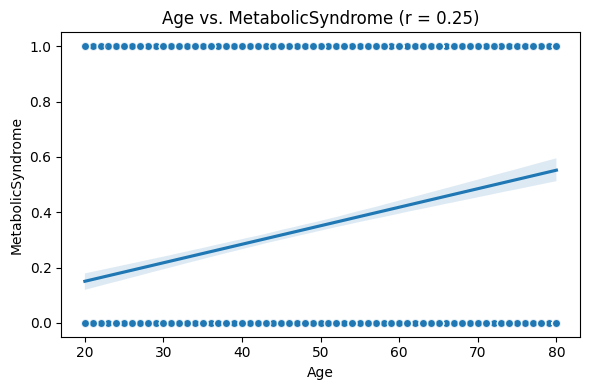

In [ ]:
#Multivariate EDA
target = 'MetabolicSyndrome'
plot_numeric_vs_target(df, age_feature, target, target_type= 'reg');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes, I would expect that age could be a predictor of metabolic syndrome as some of these health metrics get worse with age.
2. Does this feature appear to be a predictor of the target?
  - There is a slight correlation between age and metabolic syndrome diagnosis.

###Sex

- Sex: The patient's gender.

In [ ]:
#Univariate EDA
#Comfirm data type for function call
sex_feature = 'Sex'
df[sex_feature].dtype

dtype('O')

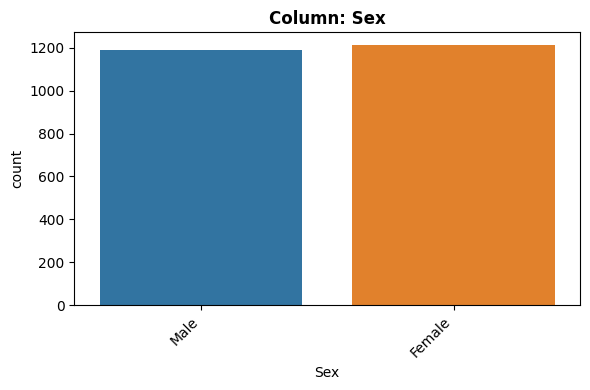

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Female' occurs 1211 times (50.44%)
- Not constant or quasi-constant.


In [ ]:
#Call categorical function
explore_categorical(df, sex_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is categorical(nominal).
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are no missing values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - The cardinality is low, with 2 unique values.
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

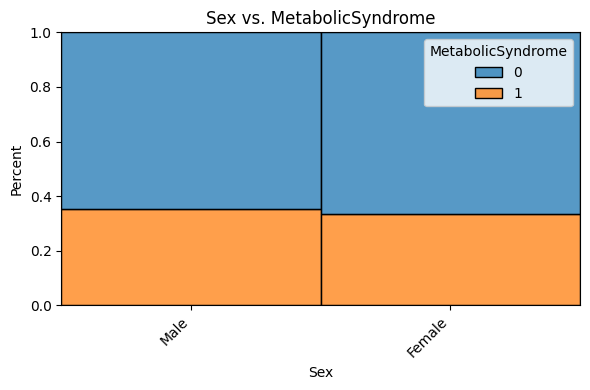

In [ ]:
#Multivariate EDA
plot_categorical_vs_target(df, sex_feature, target, target_type= 'class');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - I would not really expect sex to be a significant indicator of whether or not someone develops metabolic syndrome.
2. Does this feature appear to be a predictor of the target?
  - Even though there is a slightly higher instance of metabolic syndrome in males, this is not a strong predictor of the condition.

###Marital

- Marital: The patient's marital status.

In [ ]:
#Univariate EDA
#Comfirm data type for function call
marital_feature = 'Marital'
df[marital_feature].dtype

dtype('O')

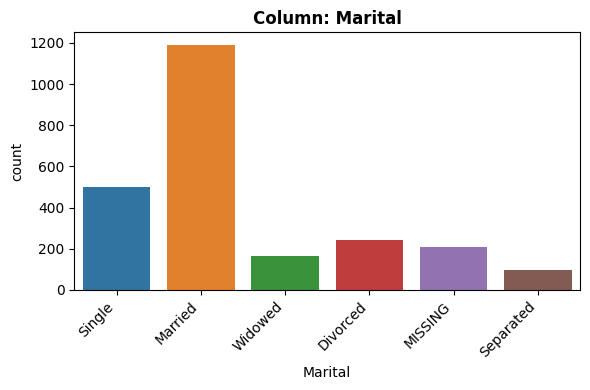

- NaN's Found: 208 (8.66%)
- Unique Values: 6
- Most common value: 'Married' occurs 1192 times (49.65%)
- Not constant or quasi-constant.


In [ ]:
#Call categorical function
explore_categorical(df, marital_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is categorical(nominal).
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 208 or 8.66% null values. I would impute them with either the most frequent, which is 'married,' or a placeholder. The placeholder will not increase the cardinality to a point where it will be unusable.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - The cardinality is medium, with 6 values.
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

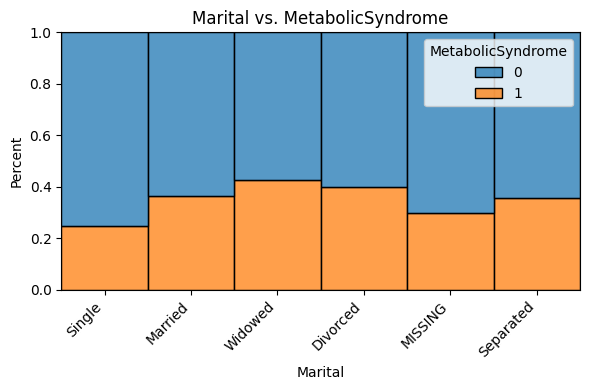

In [ ]:
#Multivariate EDA
plot_categorical_vs_target(df, marital_feature, target, target_type= 'class');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - I would not really expect marital status to be a significant indicator of whether or not someone develops metabolic syndrome.
2. Does this feature appear to be a predictor of the target?
  - Even though there is some variation between the classes here, it does not really indicate that this is a predictor of metabolic syndrome.

###Income

- Income: The patient's monthly income.

In [ ]:
#Univariate EDA
#Comfirm data type for function call
income_feature = 'Income'
df[income_feature].dtype

dtype('float64')

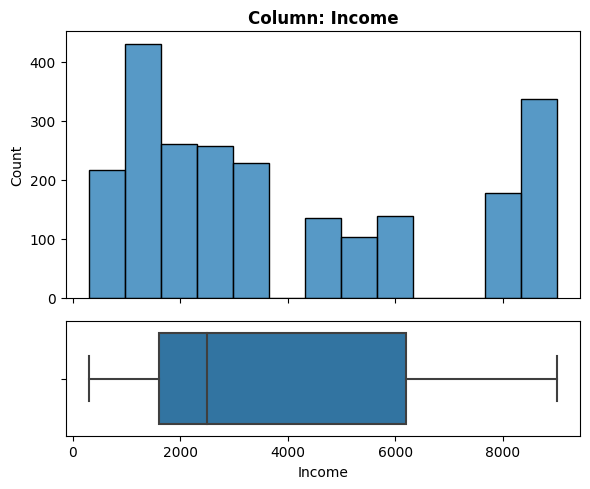

- NaN's Found: 117 (4.87%)
- Unique Values: 14
- Most common value: '9000.0' occurs 337 times (14.04%)
- Not constant or quasi-constant.


In [ ]:
#Call numeric function
explore_numeric(df, income_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 117 or 4.87% null values. These will be imputed with either the mean or the median.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

- Excluding 117 NaN's


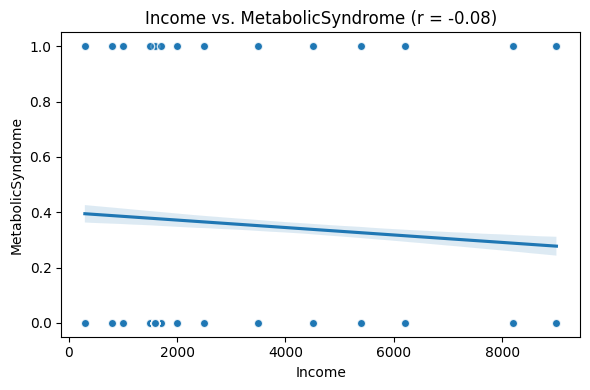

In [ ]:
#Multivariate EDA
plot_numeric_vs_target(df, income_feature, target, target_type= 'reg');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - No, I would not expect that a person's income level will directly influence whether or not they develop metabolic syndrome.
2. Does this feature appear to be a predictor of the target?
  - There is a very slight negative correlation between income and metabolic syndrome, showing that this is not a signifiant indicator of the disease.

###Race

- Race: The patient's ethnicity.

In [ ]:
#Univariate EDA
#Comfirm data type for function call
race_feature = 'Race'
df[race_feature].dtype

dtype('O')

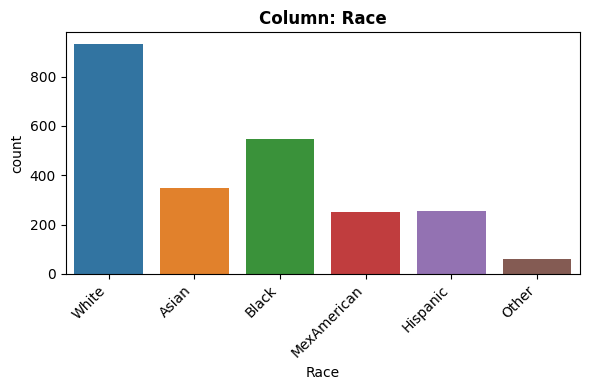

- NaN's Found: 0 (0.0%)
- Unique Values: 6
- Most common value: 'White' occurs 933 times (38.86%)
- Not constant or quasi-constant.


In [ ]:
#Call categorical function
explore_categorical(df, race_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is categorical(nominal).
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are no null values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - The cardinality is medium, with 6 values.
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

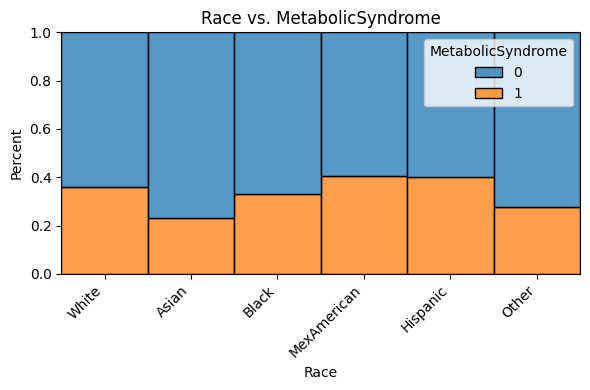

In [ ]:
#Multivariate EDA
plot_categorical_vs_target(df, race_feature, target, target_type= 'class');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - I would not really expect race to be a significant indicator of whether or not someone develops metabolic syndrome.
2. Does this feature appear to be a predictor of the target?
  - Even though there is some variation between the classes here, it does not really indicate that this is a predictor of metabolic syndrome.

###Waist Circumference

- WaistCirc: The patient's waist circumference.

In [ ]:
#Univariate EDA
#Comfirm data type for function call
waist_feature = 'WaistCirc'
df[waist_feature].dtype

dtype('float64')

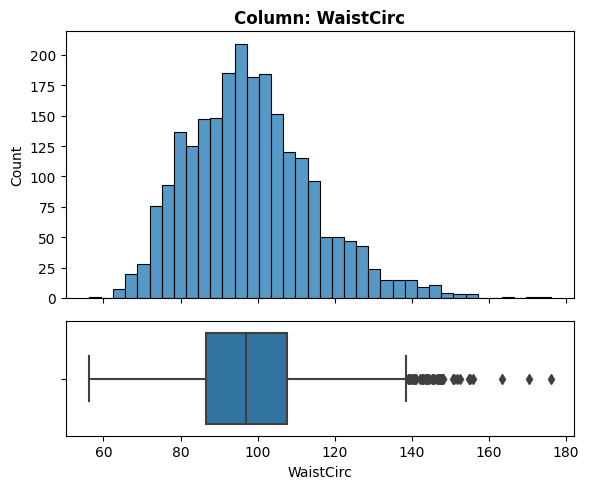

- NaN's Found: 85 (3.54%)
- Unique Values: 635
- Most common value: 'nan' occurs 85 times (3.54%)
- Not constant or quasi-constant.


In [ ]:
#Call numeric function
explore_numeric(df, waist_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 85 or 3.54% null values. These will be imputed with the median, due to the presence of outliers in this feature.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

- Excluding 85 NaN's


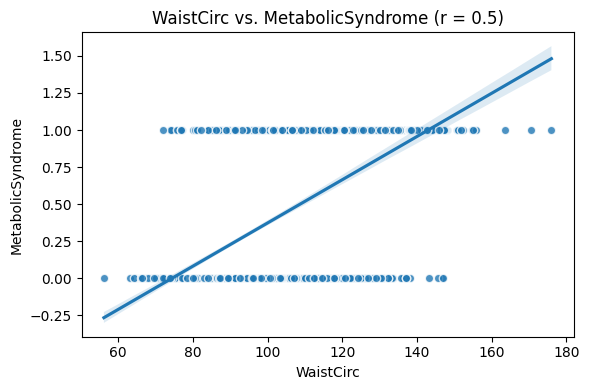

In [ ]:
#Multivariate EDA
plot_numeric_vs_target(df, waist_feature, target, target_type= 'reg');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes, knowing that a larger waist circumference can be a predictor for many health conditions, I would expect this to be a predictor of the target.
2. Does this feature appear to be a predictor of the target?
  - Yes, as there is a moderate correlation between the two.

###BMI

- BMI: The patient's BMI (Body Mass Index)

In [ ]:
#Univariate EDA
#Comfirm data type for function call
bmi_feature = 'BMI'
df[bmi_feature].dtype

dtype('float64')

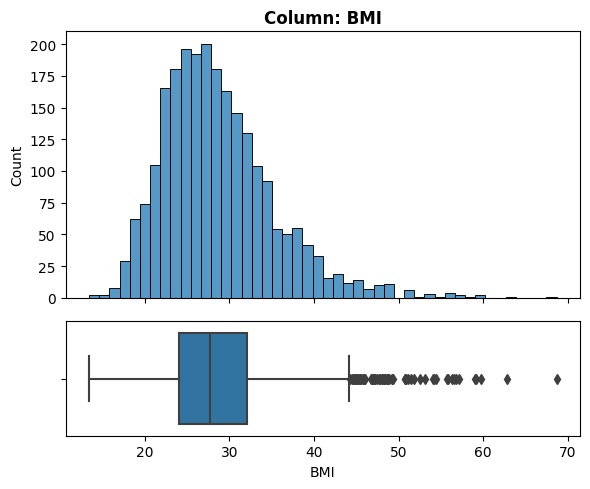

- NaN's Found: 26 (1.08%)
- Unique Values: 322
- Most common value: 'nan' occurs 26 times (1.08%)
- Not constant or quasi-constant.


In [ ]:
#Call numeric function
explore_numeric(df, bmi_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 26 or 1.08% null values. These will be imputed with the median, due to the presence of outliers in this feature.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

- Excluding 26 NaN's


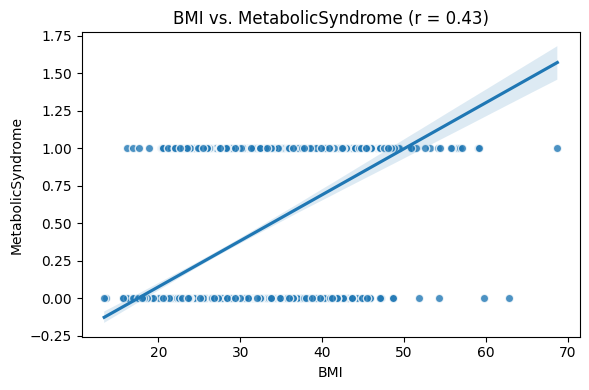

In [ ]:
#Multivariate EDA
plot_numeric_vs_target(df, bmi_feature, target, target_type= 'reg');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes, knowing that higher BMI values can be a predictor for many health conditions, I would expect this to be a predictor of the target.
2. Does this feature appear to be a predictor of the target?
  - Yes, as there is a moderate correlation between the two.

###Albuminuria

- Albuminuria: The patient's Albuminuria stage.

In [ ]:
#Univariate EDA
#Comfirm data type for function call
albumin_feature = 'Albuminuria'
df[albumin_feature].dtype

dtype('int64')

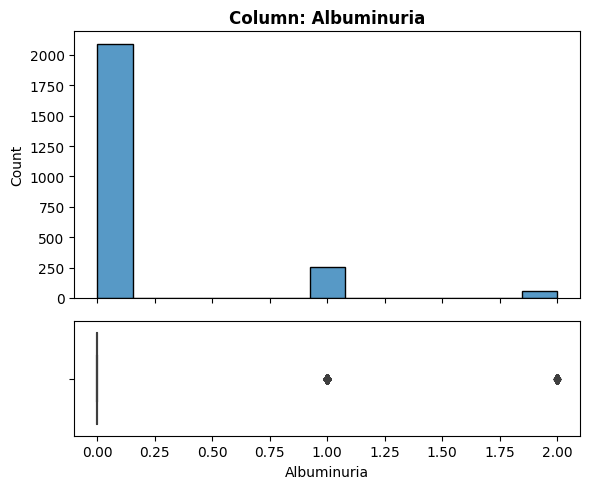

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: '0' occurs 2089 times (87.01%)
- Not constant or quasi-constant.


In [ ]:
#Call numeric function
explore_numeric(df, albumin_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

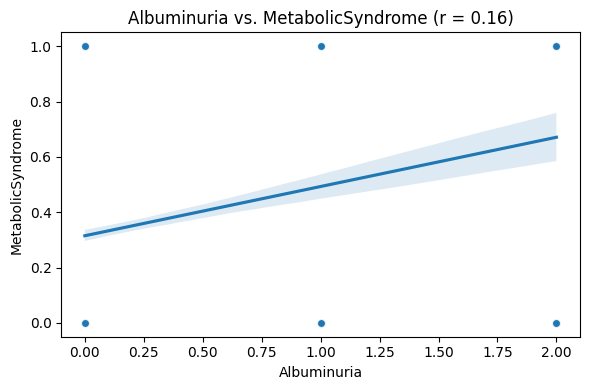

In [ ]:
#Multivariate EDA
plot_numeric_vs_target(df, albumin_feature, target, target_type= 'reg');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - I would expect that this could be a predictor of the target.
2. Does this feature appear to be a predictor of the target?
  - This is not a strong predictor of the target.

###Urine Albumin Creatinine Ratio

- UrAlbCr: The patient's Urine Albumin-Creatinine ratio.

In [ ]:
#Univariate EDA
#Comfirm data type for function call
uralbcr_feature = 'UrAlbCr'
df[uralbcr_feature].dtype

dtype('float64')

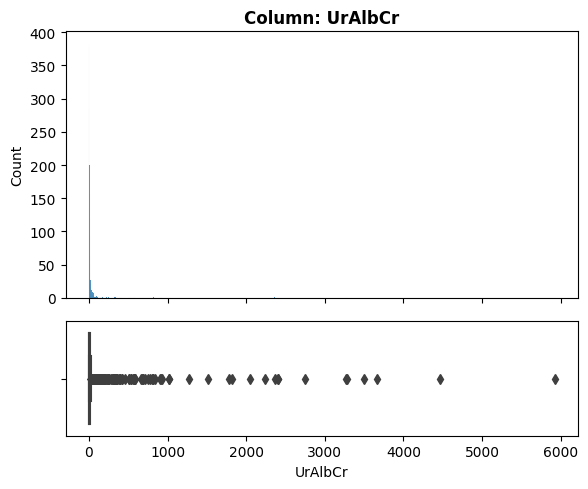

- NaN's Found: 0 (0.0%)
- Unique Values: 1383
- Most common value: '5.0' occurs 18 times (0.75%)
- Not constant or quasi-constant.


In [ ]:
#Call numeric function
explore_numeric(df, uralbcr_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

- Note: There are a lot of outliers in this feature.

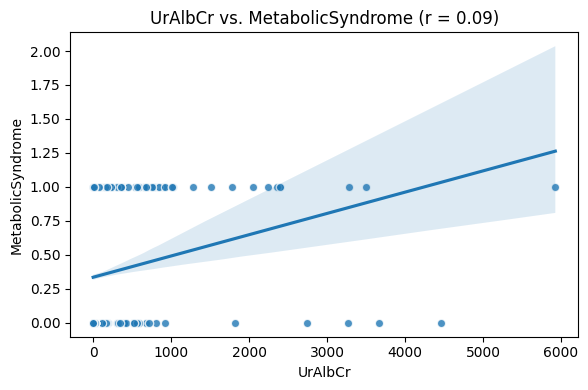

In [ ]:
#Multivariate EDA
plot_numeric_vs_target(df, uralbcr_feature, target, target_type= 'reg');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - I would expect that this could be a predictor of the target.
2. Does this feature appear to be a predictor of the target?
  - This is not a strong predictor of the target.

###Uric Acid

- UricAcid: The patient's uric acid level.

In [ ]:
#Univariate EDA
#Comfirm data type for function call
uricacid_feature = 'UricAcid'
df[uricacid_feature].dtype

dtype('float64')

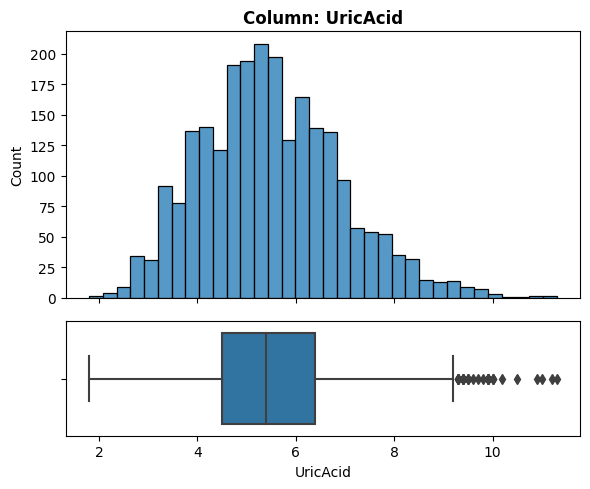

- NaN's Found: 0 (0.0%)
- Unique Values: 88
- Most common value: '5.2' occurs 77 times (3.21%)
- Not constant or quasi-constant.


In [ ]:
#Call numeric function
explore_numeric(df, uricacid_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

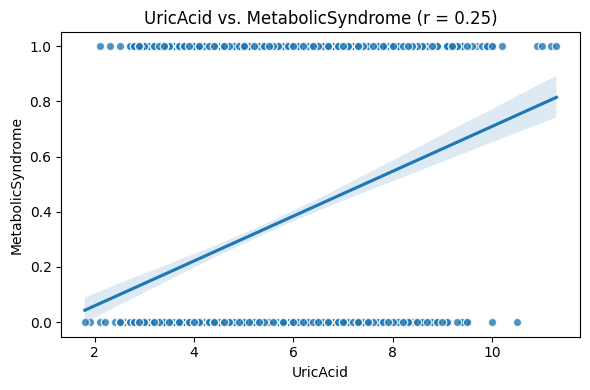

In [ ]:
#Multivariate EDA
plot_numeric_vs_target(df, uricacid_feature, target, target_type= 'reg');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - I would not expect this feature to be a predictor of the target.
2. Does this feature appear to be a predictor of the target?
  - This has a slight correlation, but is not a strong predictor of the target.

###Blood Glucose

- BloodGlucose: The patient's blood glucose level.

In [ ]:
#Univariate EDA
#Comfirm data type for function call
glucose_feature = 'BloodGlucose'
df[glucose_feature].dtype

dtype('int64')

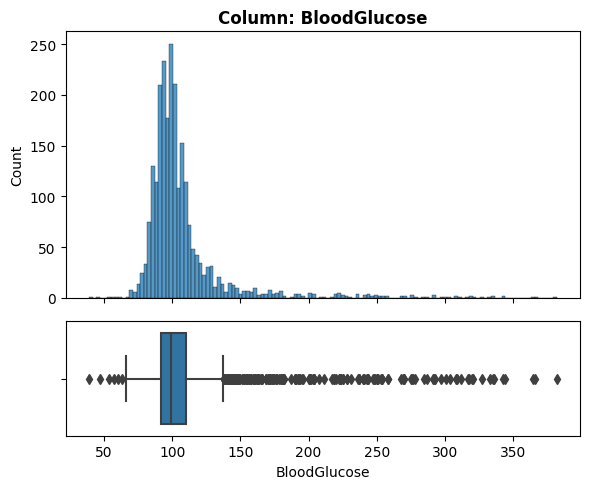

- NaN's Found: 0 (0.0%)
- Unique Values: 187
- Most common value: '97' occurs 90 times (3.75%)
- Not constant or quasi-constant.


In [ ]:
#Call numeric function
explore_numeric(df, glucose_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

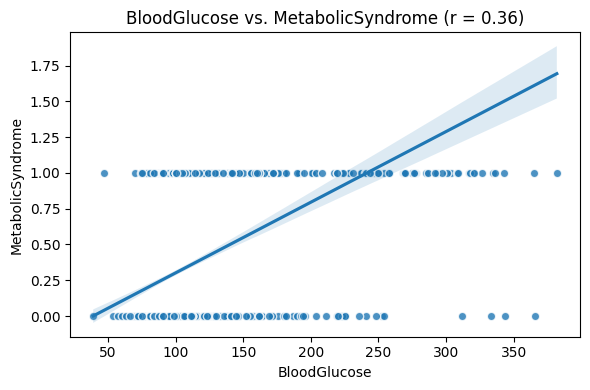

In [ ]:
#Multivariate EDA
plot_numeric_vs_target(df, glucose_feature, target, target_type= 'reg');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes, I would expect this to be a predictor of the target.
2. Does this feature appear to be a predictor of the target?
  - While the correlation is not as strong as I would have thought, this appears to be a slight predictor of the target.

###HDL

- HDL: The patient's HDL (High-Density Lipoprotein) level.

In [ ]:
#Univariate EDA
#Comfirm data type for function call
hdl_feature = 'HDL'
df[hdl_feature].dtype

dtype('int64')

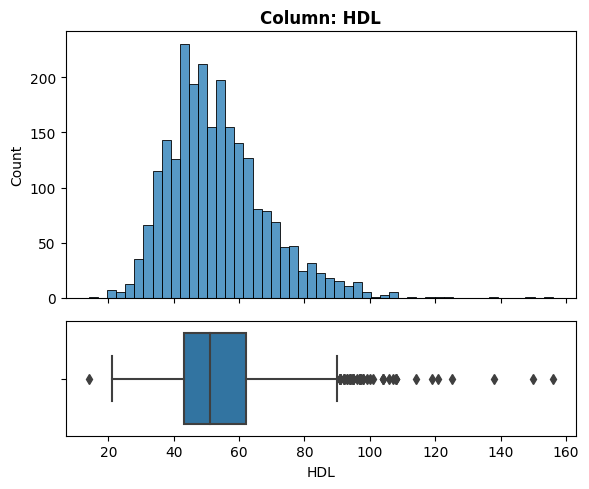

- NaN's Found: 0 (0.0%)
- Unique Values: 93
- Most common value: '48' occurs 87 times (3.62%)
- Not constant or quasi-constant.


In [ ]:
#Call numeric function
explore_numeric(df, hdl_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

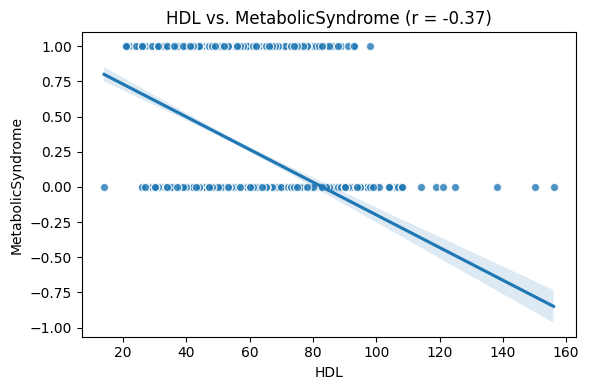

In [ ]:
#Multivariate EDA
plot_numeric_vs_target(df, hdl_feature, target, target_type= 'reg');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - I would expect that this will have an impact on the target, though I'm not sure how strong.
2. Does this feature appear to be a predictor of the target?
  - There is a slight negative correlation here, showing that if your HDL number is higher, you are potentially less likely to have metabolic syndrome.

###Triglycerides

- Triglycerides: The patient's triglycerides level.

In [ ]:
#Univariate EDA
#Comfirm data type for function call
triglyceride_feature = 'Triglycerides'
df[triglyceride_feature].dtype

dtype('int64')

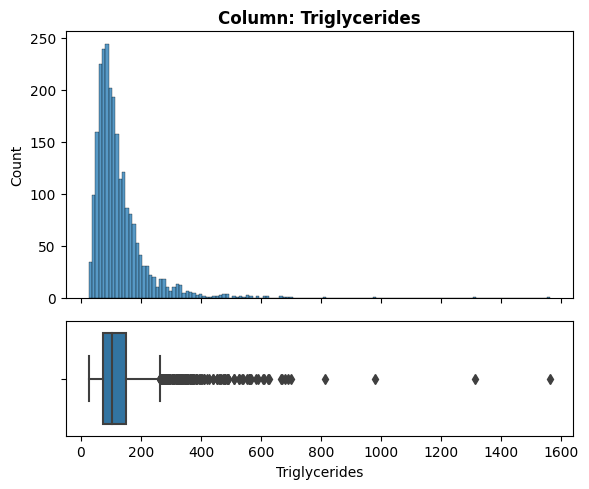

- NaN's Found: 0 (0.0%)
- Unique Values: 345
- Most common value: '75' occurs 34 times (1.42%)
- Not constant or quasi-constant.


In [ ]:
#Call numeric function
explore_numeric(df, triglyceride_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

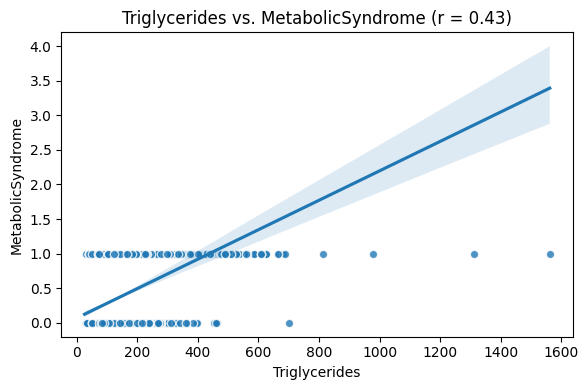

In [ ]:
#Multivariate EDA
plot_numeric_vs_target(df, triglyceride_feature, target, target_type= 'reg');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes, I would expect this to be a predictor of the target.
2. Does this feature appear to be a predictor of the target?
  - This has a moderate correlation showing that this is a predictor of the target.

###Metabolic Syndrome

- MetabolicSyndrome: Whether the patient suffers from metabolic syndrome or not.

In [ ]:
#Univariate EDA
#Comfirm data type for function call
ms_feature = 'MetabolicSyndrome'
df[ms_feature].dtype

dtype('int64')

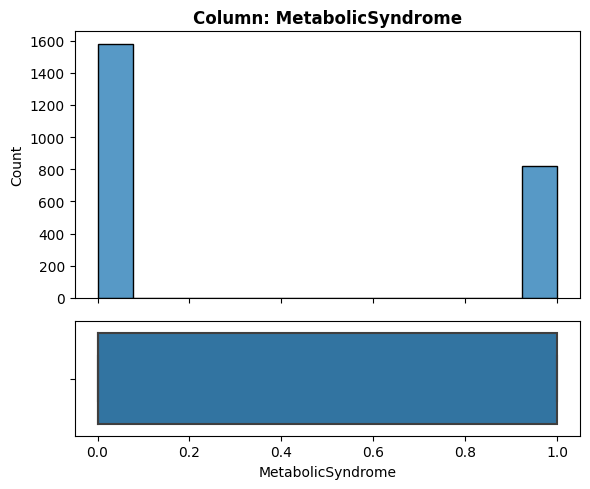

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '0' occurs 1579 times (65.76%)
- Not constant or quasi-constant.


In [ ]:
#Call numeric function
explore_numeric(df, ms_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

- No multivariate EDA needed for target feature.

##Correlations

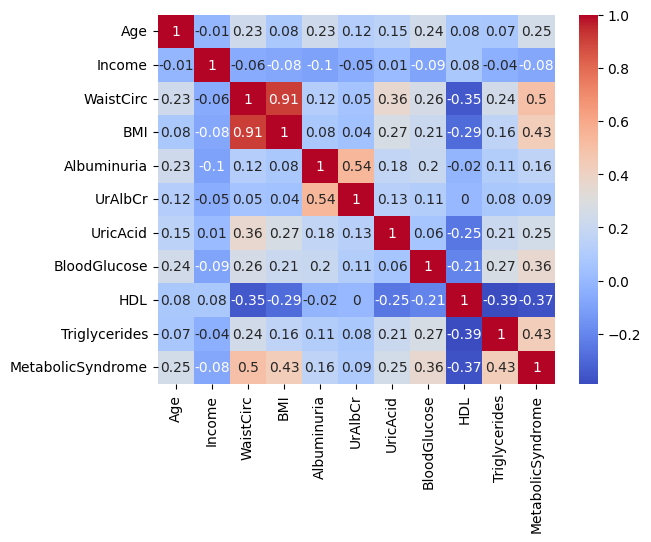

In [ ]:
#Get dataframe correlations
corr = df.corr(numeric_only= True).round(2)

#Visualize correlations with a heatmap
sns.heatmap(corr, cmap= 'coolwarm', annot= True);

- In the heatmap above, we can see several correlations, both between features and the target and between features themselves.
- The features with the strongest correlations to the target are waist circumference, BMI, triglycerides, and blood glucose. HDL has a moderate negative correlation with the target.
- These correlations are expected, as Metabolic Syndrome is the presence of multiple conditions including diabetes and heart disease. Having a larger waist circumference and BMI lead to an increased chance of developing many adverse health conditions, so this is not surprising. Because HDL is the 'good cholesterol', higher levels are better in this case, which explains the negative correlation with the target.
- HDL also has negative correlations with other features, such as waist circumference, BMI, and triglycerides.
- Waist circumference and BMI are very strongly correlated, with a value of 0.91. This shows that as one variable increases, the other is also very likely to increase as well.
- Albuminuria and urine albumin creatinine ratio are also moderately correlated with each other.

##Explanatory Visualizations

###Visualization 1

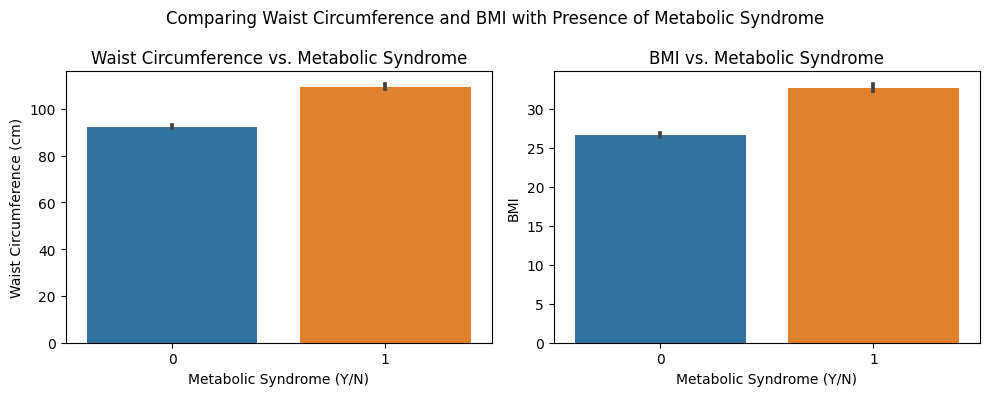

In [ ]:
##Visualization of waist circumference and BMI as related to target
#Waist circumference and target
fig, axes = plt.subplots(ncols = 2, figsize = (10,4))
sns.barplot(data= df, x= 'MetabolicSyndrome', y= 'WaistCirc', ax= axes[0])
axes[0].set_title('Waist Circumference vs. Metabolic Syndrome')
axes[0].set_ylabel('Waist Circumference (cm)')
axes[0].set_xlabel('Metabolic Syndrome (Y/N)')

#BMI and target
sns.barplot(data= df, x= 'MetabolicSyndrome', y = 'BMI', ax= axes[1])
axes[1].set_title('BMI vs. Metabolic Syndrome')
axes[1].set_ylabel('BMI')
axes[1].set_xlabel('Metabolic Syndrome (Y/N)')

fig.suptitle('Comparing Waist Circumference and BMI with Presence of Metabolic Syndrome')
fig.tight_layout();
fig.savefig('Waist_BMI.png', dpi = 300)

- The comparison shown here shows that patients who on average have higher waist circumferences as well as higher BMI values are more likely to develop metabolic syndrome.

###Visualization 2

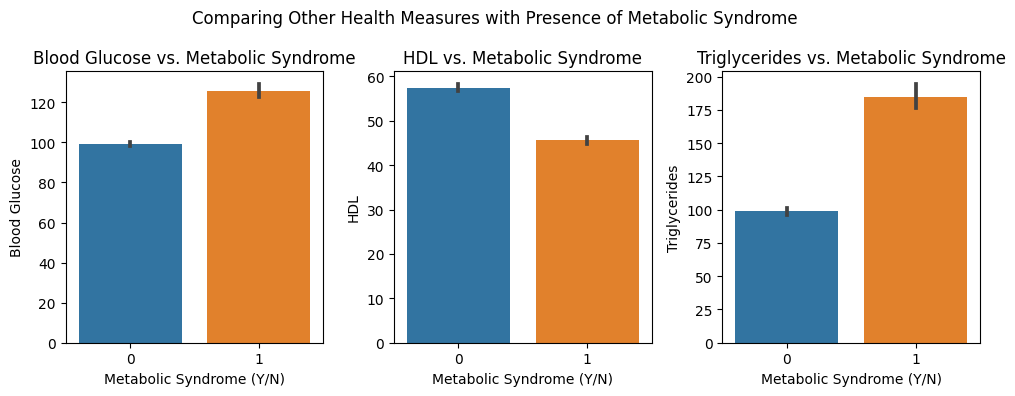

In [ ]:
##Visualization of glucose, HDL, and triglycerides as related to target
#Blood glucose and target
fig, axes = plt.subplots(ncols = 3, figsize = (10,4))
sns.barplot(data= df, x= 'MetabolicSyndrome', y= 'BloodGlucose', ax= axes[0])
axes[0].set_title('Blood Glucose vs. Metabolic Syndrome')
axes[0].set_ylabel('Blood Glucose')
axes[0].set_xlabel('Metabolic Syndrome (Y/N)')

#HDL and target
sns.barplot(data= df, x= 'MetabolicSyndrome', y = 'HDL', ax= axes[1])
axes[1].set_title('HDL vs. Metabolic Syndrome')
axes[1].set_ylabel('HDL')
axes[1].set_xlabel('Metabolic Syndrome (Y/N)')

#Triglycerides and target
sns.barplot(data= df, x= 'MetabolicSyndrome', y = 'Triglycerides', ax= axes[2])
axes[2].set_title('Triglycerides vs. Metabolic Syndrome')
axes[2].set_ylabel('Triglycerides')
axes[2].set_xlabel('Metabolic Syndrome (Y/N)')

fig.suptitle('Comparing Other Health Measures with Presence of Metabolic Syndrome')
fig.tight_layout();
fig.savefig('Health_Measures.png', dpi = 300)

- In the plot above, we see that higher blood glucose levels and higher triglycerides put patients at a higher risk of metabolic syndrome, whereas higher HDL levels are opposite. The higher the HDL, the less likely the patient is to develop metabolic syndrome.

##Pre-Processing

###Unnecessary Columns

- After completing EDA, I will drop the marital, race, income, and uralbcr columns from the dataset for machine learning. These columns either represent factors that a patient cannot control (such as their race), or columns that do not have a significant correlation with the target.

In [ ]:
#Drop columns
df = df.drop(columns = ['Marital', 'Race', 'Income', 'UrAlbCr'])

#Verify the drop
df.head()

,Age,Sex,WaistCirc,BMI,Albuminuria,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,22,Male,81.0,23.3,0,4.9,92,41,84,0
1,44,Female,80.1,23.2,0,4.5,82,28,56,0
2,21,Male,69.6,20.1,0,5.4,107,43,78,0
3,43,Female,120.4,33.3,0,5.0,104,73,141,0
4,51,Male,81.1,20.1,0,5.0,95,43,126,0


###Missing Values

In [ ]:
#Check missing values
df.isna().sum()

Age                   0
Sex                   0
WaistCirc            85
BMI                  26
Albuminuria           0
UricAcid              0
BloodGlucose          0
HDL                   0
Triglycerides         0
MetabolicSyndrome     0
dtype: int64

- There are missing values in 2 columns.
- In order to determine the best imputation strategy, I will look at the descriptive statistics for these numeric columns.

In [ ]:
#Check summary statistics for numeric columns
df.describe()

,Age,WaistCirc,BMI,Albuminuria,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
count,2401.000000,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,48.691795,98.307254,28.702189,0.154102,5.489046,108.247813,53.369429,128.125364,0.342357
std,17.632852,16.252634,6.662242,0.422780,1.439358,34.820657,15.185537,95.322477,0.474597
min,20.000000,56.200000,13.400000,0.000000,1.800000,39.000000,14.000000,26.000000,0.000000
25%,34.000000,86.675000,24.000000,0.000000,4.500000,92.000000,43.000000,75.000000,0.000000
50%,48.000000,97.000000,27.700000,0.000000,5.400000,99.000000,51.000000,103.000000,0.000000
75%,63.000000,107.625000,32.100000,0.000000,6.400000,110.000000,62.000000,150.000000,1.000000
max,80.000000,176.000000,68.700000,2.000000,11.300000,382.000000,156.000000,1562.000000,1.000000


- Because of the presence of outliers in these columns, I will impute the median. The median value is less likely to be skewed by outliers, and that makes this value more trustworthy in this case.

###Validation Split

In [ ]:
#Define X and y
target = 'MetabolicSyndrome'
X = df.drop(columns= 'MetabolicSyndrome')
y = df[target]

In [ ]:
#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y, random_state= 42)

#Verify the split
X_train.head()

,Age,Sex,WaistCirc,BMI,Albuminuria,UricAcid,BloodGlucose,HDL,Triglycerides
1352,66,Male,95.9,24.3,0,4.4,99,67,114
940,57,Male,117.5,34.4,1,7.0,115,32,148
1547,27,Male,99.2,28.9,0,6.3,84,43,81
59,70,Female,125.4,40.6,0,4.8,144,45,148
1098,61,Male,115.5,33.6,1,5.3,155,37,151


In [ ]:
#Check class balance of target
y_train.value_counts(normalize= True)

0    0.657778
1    0.342222
Name: MetabolicSyndrome, dtype: float64

- There is some imbalance in these classes, and will need to be taken care of appropriately during the modeling phase.

###Pre-Processing Object

In [ ]:
##Create numeric pipeline
num_cols = X_train.select_dtypes('number').columns

#Instantiate transformers
impute_median = SimpleImputer(strategy= 'median')
scaler = StandardScaler()

#Instantiate pipeline
num_pipe = make_pipeline(impute_median, scaler)

#Number column tuple
num_tuple = ('Numeric', num_pipe, num_cols)


In [ ]:
##Create categorical pipeline for gender column
cat_cols = X_train.select_dtypes('object').columns

#Instantiate transformers
ohe = OneHotEncoder(sparse_output= False, handle_unknown= 'ignore')

#Instantiate pipeline
ohe_pipe = make_pipeline(ohe)

#Categorical column tuple
ohe_tuple = ('Categorical', ohe_pipe, cat_cols)

In [ ]:
#Instantiate Column Transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple], verbose_feature_names_out= False)

#View the preprocessor to verify it is correct
preprocessor

ColumnTransformer(transformers=[('Numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Age', 'WaistCirc', 'BMI', 'Albuminuria', 'UricAcid', 'BloodGlucose',
       'HDL', 'Triglycerides'],
      dtype='object')),
                                ('Categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Sex'], dtype='object'))],
                  verbose_feature_names_out=False)

##Modeling

###Random Forest Classifier

####Default Model

In [ ]:
#Instantiate default model
rf = RandomForestClassifier(random_state= 42)

#Create model pipeline
rf_pipe = make_pipeline(preprocessor, rf)

#Fit pipeline on training data
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'WaistCirc', 'BMI', 'Albuminuria', 'UricAcid', 'BloodGlucose',
       'HDL', 'Triglycerides'],
      dtype='object')),
                                                 ('Categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Sex'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1184
           1       1.00      1.00      1.00       616

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



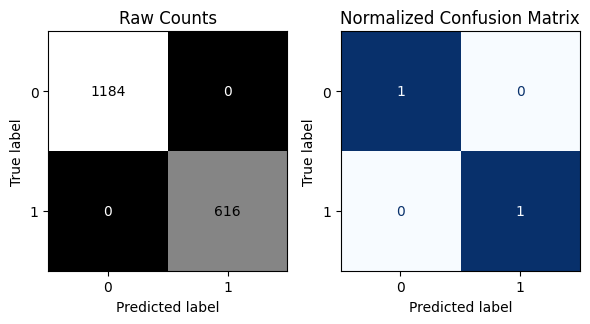


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       395
           1       0.84      0.82      0.83       206

    accuracy                           0.89       601
   macro avg       0.88      0.87      0.87       601
weighted avg       0.89      0.89      0.89       601



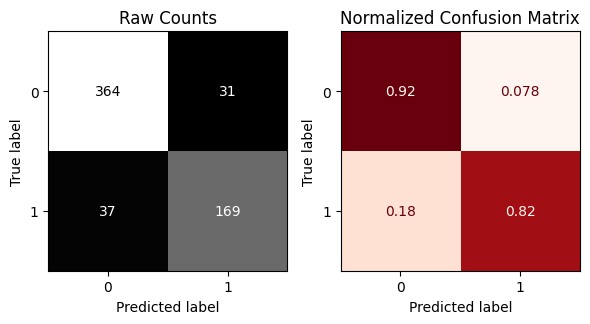

In [ ]:
#Evaluate default model 1
evaluate_classification(rf_pipe, X_train, y_train, X_test, y_test)

- This model performs well, with an overall accuracy of 89%.
- I would like to reduce the number of false negatives, as I believe these are the worse errors to make in this case.
- The classes are still slightly unbalanced, so the accuracy is a little misleading.

####Tuned Model

In [ ]:
#Get list of parameters
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('Numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Age', 'WaistCirc', 'BMI', 'Albuminuria', 'UricAcid', 'BloodGlucose',
          'HDL', 'Triglycerides'],
         dtype='object')),
                                   ('Categorical',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    Index(['Sex'], dtype='object'))],
                     verbose_feature_names_out=Fal

In [ ]:
#Create dictionary of values to use for tuning
rf_params = {'randomforestclassifier__n_estimators': [1, 10, 50, 100, 150, 200],
             'randomforestclassifier__max_depth': [None, 1, 10, 20],
             'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss'],
             'randomforestclassifier__class_weight': [None, 'balanced']}

In [ ]:
#Instantiate GridSearchCV
grid_search = GridSearchCV(rf_pipe, rf_params, verbose= True, n_jobs= -1, scoring = 'recall_macro')

#Fit on training data
grid_search.fit(X_train, y_train)

#Get best parameters
grid_search.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


{'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__n_estimators': 50}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1184
           1       0.95      1.00      0.98       616

    accuracy                           0.98      1800
   macro avg       0.98      0.99      0.98      1800
weighted avg       0.98      0.98      0.98      1800



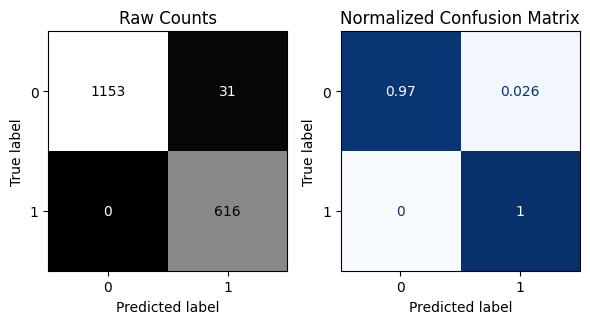


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       395
           1       0.81      0.84      0.82       206

    accuracy                           0.88       601
   macro avg       0.86      0.87      0.86       601
weighted avg       0.88      0.88      0.88       601



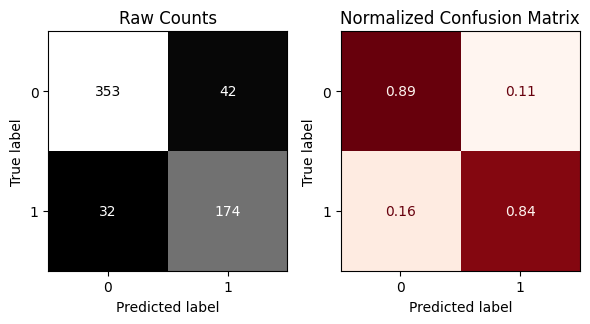

In [ ]:
#Instantiate best model
best_rf = grid_search.best_estimator_

#Evaluate best model
evaluate_classification(best_rf, X_train, y_train, X_test, y_test)

- Tuning the random forest did decrease false negatives overall, which is what I had hoped for.
- Even though the overall accuracy dropped, I don't view that as a negative since the tuning balanced the classes.

###K-Nearest Neighbors

####Default Model

In [ ]:
#Instantiate default model
knn = KNeighborsClassifier()

#Create model pipeline
knn_pipe = make_pipeline(preprocessor, knn)

#Fit pipeline on training data
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'WaistCirc', 'BMI', 'Albuminuria', 'UricAcid', 'BloodGlucose',
       'HDL', 'Triglycerides'],
      dtype='object')),
                                                 ('Categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Sex'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1184
           1       0.87      0.81      0.84       616

    accuracy                           0.89      1800
   macro avg       0.89      0.87      0.88      1800
weighted avg       0.89      0.89      0.89      1800



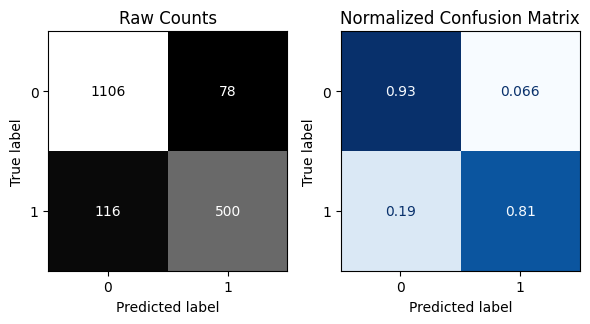


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.92      0.88       395
           1       0.82      0.65      0.72       206

    accuracy                           0.83       601
   macro avg       0.82      0.78      0.80       601
weighted avg       0.83      0.83      0.82       601



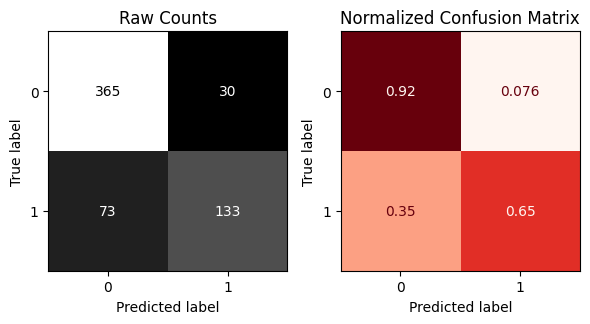

In [ ]:
#Evaluate default model 2
evaluate_classification(knn_pipe, X_train, y_train, X_test, y_test)

- This model also performs well, but not as well as the Random Forest. It has a lower accuracy and a higher rate of false negatives.

####Tuned Model

In [ ]:
#Get list of parameters to tune
knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('Numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Age', 'WaistCirc', 'BMI', 'Albuminuria', 'UricAcid', 'BloodGlucose',
          'HDL', 'Triglycerides'],
         dtype='object')),
                                   ('Categorical',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    Index(['Sex'], dtype='object'))],
                     verbose_feature_names_out=Fal

In [ ]:
#Create list of numbers for the n_neighbors parameter
k_list = list(range(1,50,2))
k_list

[1,
 3,
 5,
 7,
 9,
 11,
 13,
 15,
 17,
 19,
 21,
 23,
 25,
 27,
 29,
 31,
 33,
 35,
 37,
 39,
 41,
 43,
 45,
 47,
 49]

In [ ]:
#Create dictionary of parameters to try for tuning
knn_params = {'kneighborsclassifier__n_neighbors': k_list,
              'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'kneighborsclassifier__weights': ['uniform', 'distance']}

In [ ]:
#Instantiate GridSearchCV
grid_search = GridSearchCV(knn_pipe, knn_params, verbose= True, n_jobs= -1, scoring = 'recall_macro')

#Fit on training data
grid_search.fit(X_train, y_train)

#Get best parameters
grid_search.best_params_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


{'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__n_neighbors': 27,
 'kneighborsclassifier__weights': 'distance'}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1184
           1       1.00      1.00      1.00       616

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



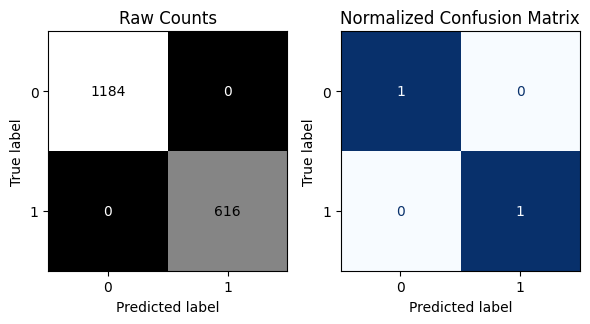


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       395
           1       0.85      0.66      0.74       206

    accuracy                           0.84       601
   macro avg       0.85      0.80      0.82       601
weighted avg       0.84      0.84      0.84       601



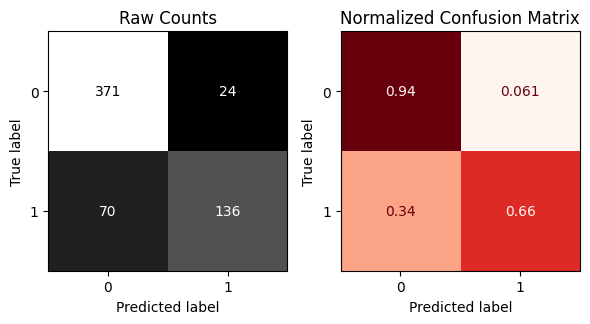

In [ ]:
#Instantiate best model
best_knn = grid_search.best_estimator_

#Evaluate best model
evaluate_classification(best_knn, X_train, y_train, X_test, y_test)

- Tuning this model did improve its' performance slightly, but it is still not as good as the random forests.

###Logistic Regression

####Default Model

In [ ]:
#Instantiate default model
logreg = LogisticRegression(random_state= 42, class_weight= 'balanced')

#Create model pipeline
logreg_pipe = make_pipeline(preprocessor, logreg)

#Fit pipeline on training data
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'WaistCirc', 'BMI', 'Albuminuria', 'UricAcid', 'BloodGlucose',
       'HDL', 'Triglycerides'],
      dtype='object')),
                                                 ('Categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Sex'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      1184
           1       0.73      0.84      0.78       616

    accuracy                           0.84      1800
   macro avg       0.82      0.84      0.83      1800
weighted avg       0.85      0.84      0.84      1800



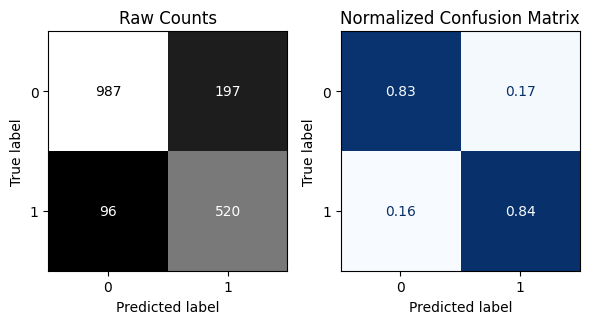


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       395
           1       0.72      0.79      0.76       206

    accuracy                           0.83       601
   macro avg       0.81      0.82      0.81       601
weighted avg       0.83      0.83      0.83       601



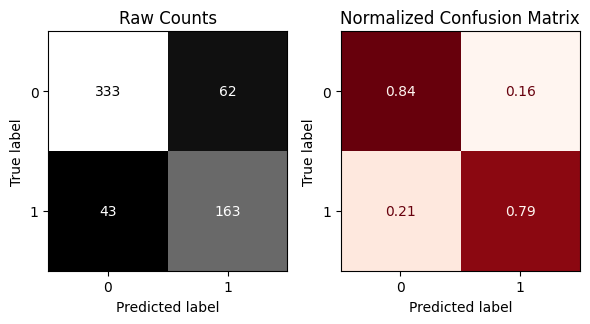

In [ ]:
#Evaluate default model 3
evaluate_classification(logreg_pipe, X_train, y_train, X_test, y_test)

- Again, this model performs pretty well as a default, but still is not as good as the random forest models.

####Tuned Model

In [ ]:
#Obtain parameters for tuning
logreg_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('Numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Age', 'WaistCirc', 'BMI', 'Albuminuria', 'UricAcid', 'BloodGlucose',
          'HDL', 'Triglycerides'],
         dtype='object')),
                                   ('Categorical',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    Index(['Sex'], dtype='object'))],
                     verbose_feature_names_out=Fal

In [ ]:
##Create parameter dictionaries for GridSearch CV
#Params compatible with penality='elasticnet'
elasticnet_params = {'logisticregression__solver' : ['saga'],
               'logisticregression__penalty' : ['elasticnet'],
                'logisticregression__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4,
                                                 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
#Params compatible with penality='l2'
l2_params = {'logisticregression__solver': ['lbfgs', 'liblinear', 'newton-cg',
                                            'newton-cholesky', 'sag', 'saga'],
                  'logisticregression__penalty' : ['l2'],
                  'logisticregression__C': [0.0001, 0.001, 0.01, 0.1,
                                            1, 10, 100, 1000] }
#Params compatible with penality='l1'
l1_params = {'logisticregression__solver' : ['liblinear', 'saga'],
               'logisticregression__penalty' : ['l1'],
                'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                          10, 100, 1000]}
#Params with no penality
none_params = {'logisticregression__solver' : ['lbfgs', 'newton-cg',
                                               'newton-cholesky', 'sag', 'saga'],
               'logisticregression__penalty' : [None]}

#List of the param dictionaries
param_grid = [l2_params, l1_params, elasticnet_params, none_params]

In [ ]:
#Instantiate GridSearch
grid_search = GridSearchCV(logreg_pipe, param_grid, verbose= True, n_jobs= -1, scoring = 'recall_macro')

#Fit gridsearch on training data
grid_search.fit(X_train, y_train)

#Obtain best parameters
grid_search.best_params_

Fitting 5 folds for each of 80 candidates, totalling 400 fits


{'logisticregression__C': 1,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'liblinear'}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      1184
           1       0.73      0.84      0.78       616

    accuracy                           0.84      1800
   macro avg       0.82      0.84      0.83      1800
weighted avg       0.85      0.84      0.84      1800



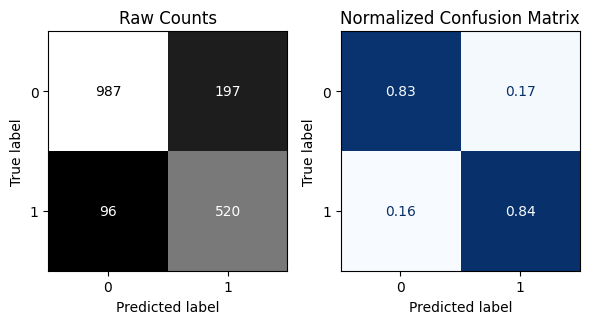


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       395
           1       0.72      0.79      0.76       206

    accuracy                           0.83       601
   macro avg       0.81      0.82      0.81       601
weighted avg       0.83      0.83      0.83       601



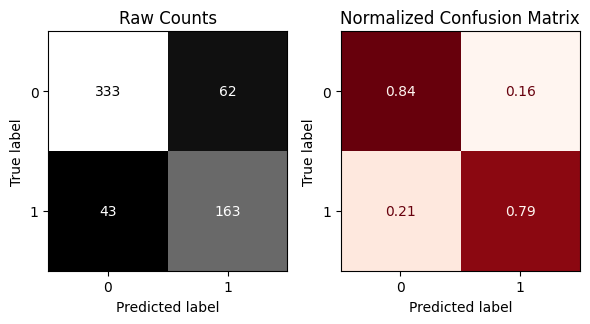

In [ ]:
#Evaluate best model
best_logreg = grid_search.best_estimator_
evaluate_classification(best_logreg, X_train, y_train, X_test, y_test)

- Tuning this model did not affect the number of false negatives, or increase/decrease the accuracy, therefore, it still did not outperform the random forest models.

###Gradient Boosting

####Default Model

In [ ]:
#Instantiate boosting model
gbc = GradientBoostingClassifier()

#Create model pipeline
gbc_pipe = make_pipeline(preprocessor, gbc)

#Fit onto training data
gbc_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'WaistCirc', 'BMI', 'Albuminuria', 'UricAcid', 'BloodGlucose',
       'HDL', 'Triglycerides'],
      dtype='object')),
                                                 ('Categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Sex'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1184
           1       0.93      0.91      0.92       616

    accuracy                           0.95      1800
   macro avg       0.94      0.94      0.94      1800
weighted avg       0.95      0.95      0.95      1800



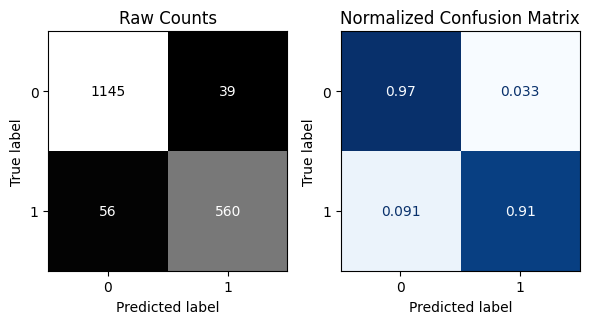


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       395
           1       0.84      0.82      0.83       206

    accuracy                           0.89       601
   macro avg       0.87      0.87      0.87       601
weighted avg       0.88      0.89      0.88       601



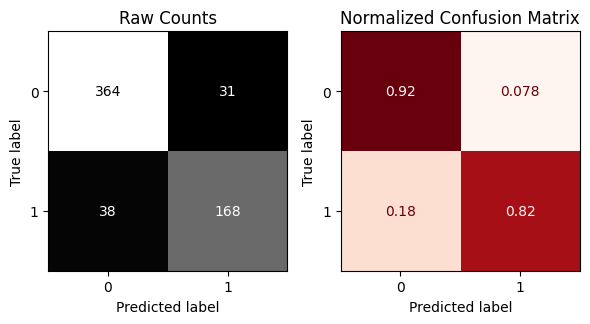

In [ ]:
#Evaluate model
evaluate_classification(gbc_pipe, X_train, y_train, X_test, y_test)

- This default boosting algorithm performs well, and almost matches the performance of the tuned random forest. I will tune this model as well to try to get even better results.

####Tuned Model

In [ ]:
#Obtain list of parameters
gbc_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('Numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Age', 'WaistCirc', 'BMI', 'Albuminuria', 'UricAcid', 'BloodGlucose',
          'HDL', 'Triglycerides'],
         dtype='object')),
                                   ('Categorical',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    Index(['Sex'], dtype='object'))],
                     verbose_feature_names_out=Fal

In [ ]:
#Create dictionary of parameter values to try
gbc_params = {'gradientboostingclassifier__max_depth': [3, 5, 7],
              'gradientboostingclassifier__n_estimators': [10, 50, 100, 150],
              'gradientboostingclassifier__loss': ['log_loss', 'exponential']}

In [ ]:
#Instantiate GridSearch
grid_search = GridSearchCV(gbc_pipe, gbc_params, verbose= True, n_jobs= -1, scoring = 'recall_macro')

#Fit gridsearch on training data
grid_search.fit(X_train, y_train)

#Obtain best parameters
grid_search.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'gradientboostingclassifier__loss': 'log_loss',
 'gradientboostingclassifier__max_depth': 5,
 'gradientboostingclassifier__n_estimators': 50}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1184
           1       0.97      0.97      0.97       616

    accuracy                           0.98      1800
   macro avg       0.97      0.97      0.97      1800
weighted avg       0.98      0.98      0.98      1800



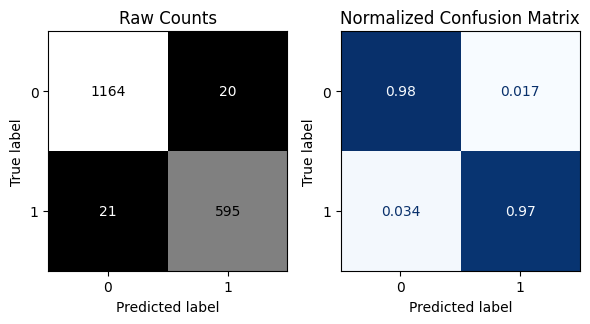


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       395
           1       0.85      0.81      0.83       206

    accuracy                           0.89       601
   macro avg       0.88      0.87      0.87       601
weighted avg       0.89      0.89      0.89       601



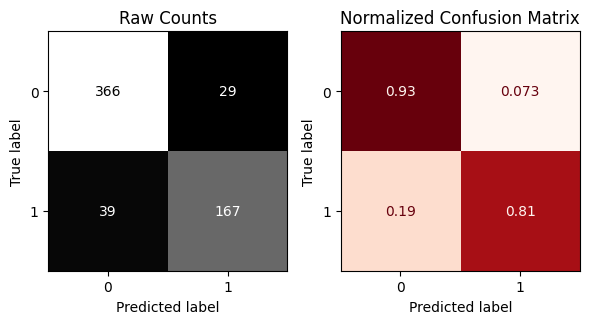

In [ ]:
#Instantiate best model
best_gbc = grid_search.best_estimator_

#Evaluate best model
evaluate_classification(best_gbc, X_train, y_train, X_test, y_test)

- Tuning these parameters did not result in an improvement. The default version of this boosting model would be better to use in this case.

###Light GBM

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
#Instantiate model
lgbm = LGBMClassifier()

#Create model pipeline
lgbm_pipe = make_pipeline(preprocessor, lgbm)

#Fit onto training data
lgbm_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'WaistCirc', 'BMI', 'Albuminuria', 'UricAcid', 'BloodGlucose',
       'HDL', 'Triglycerides'],
      dtype='object')),
                                                 ('Categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Sex'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('lgbmclassifier', LGBMClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1184
           1       1.00      1.00      1.00       616

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



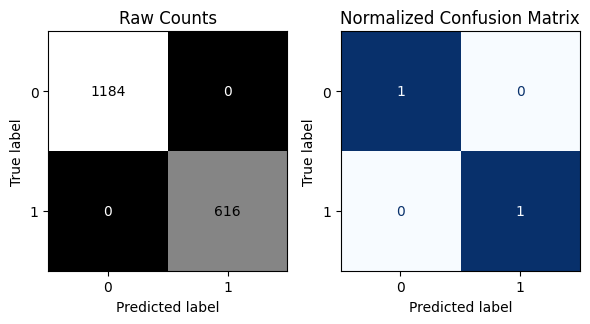


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       395
           1       0.84      0.79      0.81       206

    accuracy                           0.88       601
   macro avg       0.87      0.85      0.86       601
weighted avg       0.87      0.88      0.87       601



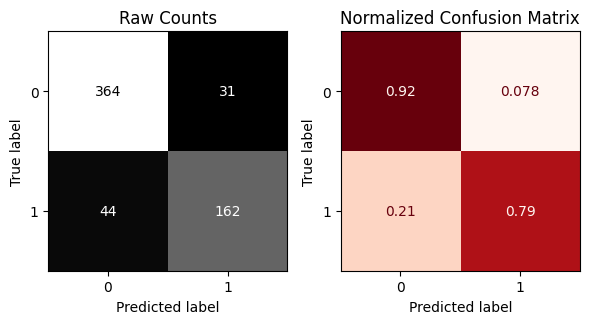

In [ ]:
#Evaluate model
evaluate_classification(lgbm_pipe, X_train, y_train, X_test, y_test)

- This algorithm did not perform as well as the others, and I will not tune try to tune it.

###XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
#Instantiate model
xgb = XGBClassifier()

#Create pipeline
xgb_pipe = make_pipeline(preprocessor, xgb)

#Fit onto training data
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'WaistCirc', 'BMI', 'Albuminuria', 'UricAcid', 'BloodGlucose',
       'HDL', 'Triglycerides'],
      dtype='object')),
                                                 ('Categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHot...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1184
           1       1.00      1.00      1.00       616

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



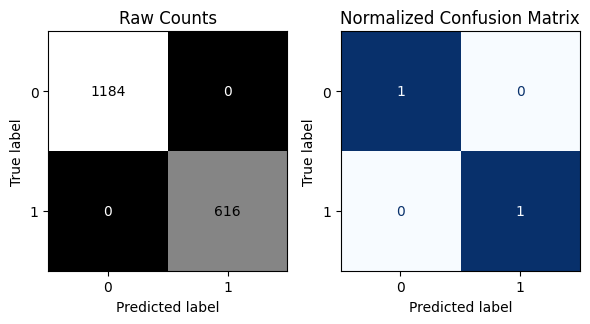


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       395
           1       0.84      0.81      0.82       206

    accuracy                           0.88       601
   macro avg       0.87      0.86      0.87       601
weighted avg       0.88      0.88      0.88       601



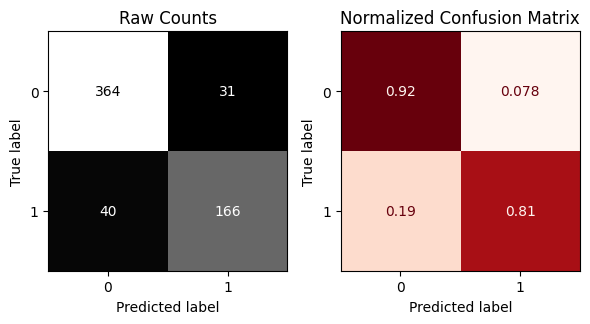

In [ ]:
#Evaluate model
evaluate_classification(xgb_pipe, X_train, y_train, X_test, y_test)

- This algorithm did not perform as well as the others, and I will not tune try to tune it.

###Ada Boost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
#Instantiate model
ada = AdaBoostClassifier()

#Create pipeline
ada_pipe = make_pipeline(preprocessor, ada)

#Fit onto training data
ada_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'WaistCirc', 'BMI', 'Albuminuria', 'UricAcid', 'BloodGlucose',
       'HDL', 'Triglycerides'],
      dtype='object')),
                                                 ('Categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Sex'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('adaboostclassifier', AdaBoostClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1184
           1       0.86      0.84      0.85       616

    accuracy                           0.90      1800
   macro avg       0.89      0.88      0.89      1800
weighted avg       0.90      0.90      0.90      1800



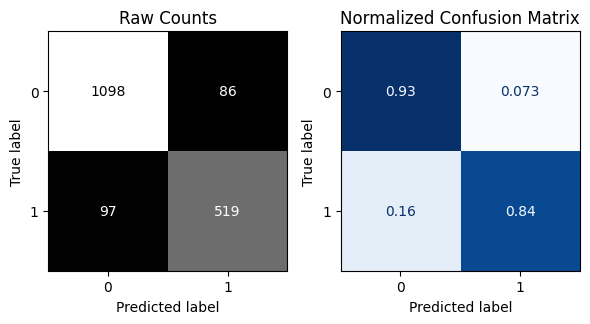


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       395
           1       0.84      0.78      0.81       206

    accuracy                           0.87       601
   macro avg       0.86      0.85      0.86       601
weighted avg       0.87      0.87      0.87       601



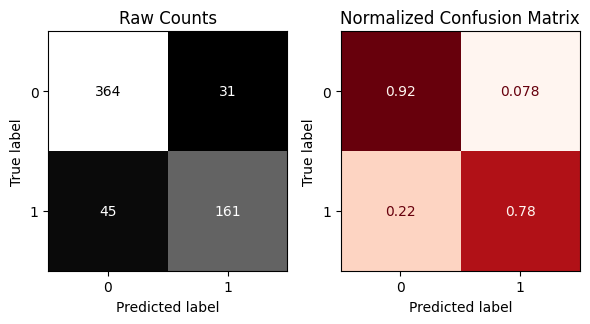

In [ ]:
#Evaluate model
evaluate_classification(ada_pipe, X_train, y_train, X_test, y_test)

- This algorithm did not perform as well as the others, and I will not tune try to tune it.

##PCA

- I will also try using PCA on the best model from above, which is the Tuned Random Forest, to see if PCA will also increase the predictive ability.

###PCA on Default Random Forest

In [ ]:
#Instantiate PCA
pca = PCA(n_components= .95)

#Create PCA pipeline with rf model
pca_rf_pipe = make_pipeline(preprocessor, pca, rf)

#Fit pca pipeline onto training data
pca_rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'WaistCirc', 'BMI', 'Albuminuria', 'UricAcid', 'BloodGlucose',
       'HDL', 'Triglycerides'],
      dtype='object')),
                                                 ('Categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Sex'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('pca', PCA(n_components=0.95)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1184
           1       1.00      1.00      1.00       616

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



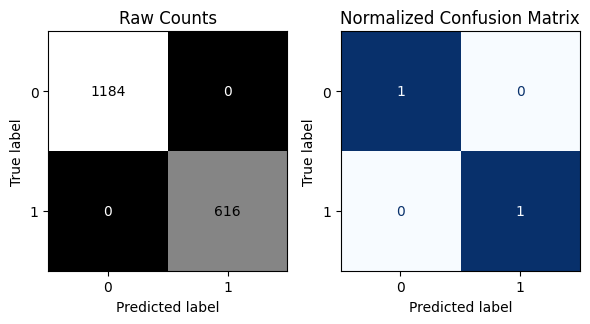


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       395
           1       0.77      0.70      0.73       206

    accuracy                           0.83       601
   macro avg       0.81      0.80      0.80       601
weighted avg       0.82      0.83      0.82       601



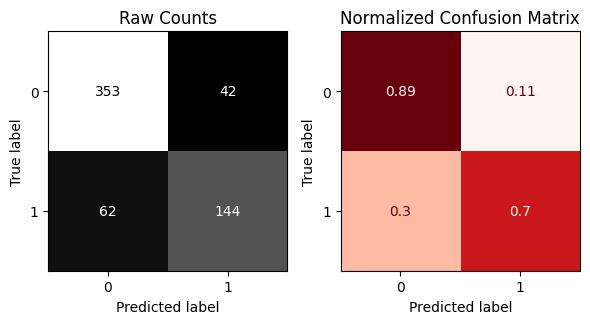

In [ ]:
#Evaluate pca model
evaluate_classification(pca_rf_pipe, X_train, y_train, X_test, y_test)

###Tuned PCA Model

In [ ]:
#Obtain parameters to tune pca_rf_pipe
pca_rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('Numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Age', 'WaistCirc', 'BMI', 'Albuminuria', 'UricAcid', 'BloodGlucose',
          'HDL', 'Triglycerides'],
         dtype='object')),
                                   ('Categorical',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    Index(['Sex'], dtype='object'))],
                     verbose_feature_names_out=Fal

In [ ]:
#Create dictionary of values to use for tuning
pca_rf_params = {'randomforestclassifier__n_estimators': [1, 10, 50, 100, 150, 200],
             'randomforestclassifier__max_depth': [None, 1, 10, 20],
             'randomforestclassifier__class_weight': [None, 'balanced'],
             'pca__n_components': [0.80, 0.85, 0.90, 0.95]}

In [ ]:
#Instantiate GridSearchCV
grid_search = GridSearchCV(pca_rf_pipe, rf_params, verbose= True, n_jobs= -1, scoring = 'recall_macro')

#Fit on training data
grid_search.fit(X_train, y_train)

#Get best parameters
grid_search.best_params_

Fitting 5 folds for each of 192 candidates, totalling 960 fits


{'pca__n_components': 0.85,
 'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__n_estimators': 100}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1184
           1       0.94      0.97      0.96       616

    accuracy                           0.97      1800
   macro avg       0.96      0.97      0.97      1800
weighted avg       0.97      0.97      0.97      1800



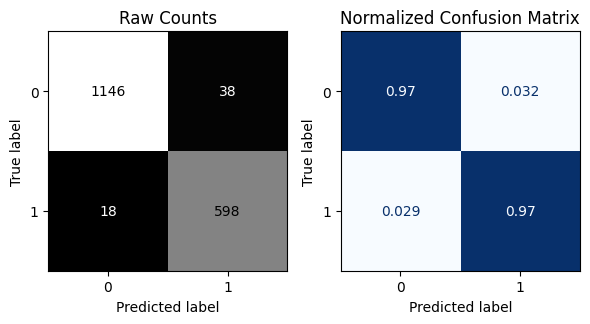


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       395
           1       0.76      0.73      0.75       206

    accuracy                           0.83       601
   macro avg       0.81      0.81      0.81       601
weighted avg       0.83      0.83      0.83       601



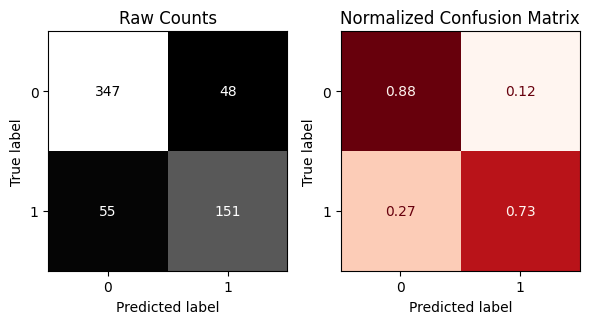

In [ ]:
#Instantiate best model
best_pca_rf = grid_search.best_estimator_

#Evaluate best model
evaluate_classification(best_pca_rf, X_train, y_train, X_test, y_test)

- While using PCA on this particular model improved with tuning, it still did not perform as well as the models without PCA.
- This could likely be due to the presence of outliers in the data set.

##Results and Recommendations

- Overall, the model that I would recommend using for predictions of metabolic syndrome is the tuned random forest model. This model performed the best overall, while having the lowest amount of false negatives (Type II errors). These errors are worse in this case because they predict that someone does not have metabolic syndrome, when they actually do, causing them to potentially go untreated.
- As expected, the features with the highest correlation to the diagnosis of metabolic syndrome were waist circumference, BMI, blood glucose, HDL, and triglycerides. We also see other strong correlations between features, such as waist circumference and BMI.
- Based on this data, the best advice to give to patients at risk of developing metabolic syndrome is to ensure a healthy lifestyle in order to maintain lower measurements for waist circumference, BMI, blood glucose, and triglycerides, while aiming for higher HDL levels.

## Tableau Visualizations

https://public.tableau.com/views/MetabolicSyndrome/MetSynbySexRace?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link